<a href="https://colab.research.google.com/github/moustafa-7/GANs_MNIST/blob/master/GANs_loss_function_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchvision tensorboardx jupyter matplotlib numpy

In [0]:
import os
os.chdir("/content/drive/My Drive/GANs_MNIST_loss function_b")

In [26]:
!ls

data  dataset  __pycache__  runs  utils.py  wieghts


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
from utils import Logger

In [0]:
def mnist_data():
  compose = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((.5,),(.5,))]
  )
  output_dir = './dataset'
  return datasets.MNIST(root=output_dir, train=True, transform=compose, download=True)

#load data
data = mnist_data()

#data loader to iterate over it and train
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

#Number of batches
num_batches = len(data_loader)


In [0]:
# The Descriminator
class DNet(torch.nn.Module):
  def __init__(self):
    super(DNet, self).__init__()

    len_features = 28*28
    len_out = 1


    self.h0 = nn.Sequential(nn.Linear(len_features, 1024),
                            nn.LeakyReLU(0.2),
                            nn.Dropout(0.3))
    
    self.h1 = nn.Sequential(nn.Linear(1024,512),
                            nn.LeakyReLU(0.2),
                            nn.Dropout(0.3))
    
    self.h2 = nn.Sequential(nn.Linear(512,256),
                            nn.LeakyReLU(0.2),
                            nn.Dropout(0.3))
    
    self.out = nn.Sequential(nn.Linear(256, len_out),
                             nn.Sigmoid())
    
  def forward(self, x):
    x = self.h0(x)
    x = self.h1(x)
    x = self.h2(x)
    x = self.out(x)
    return x

dnet = DNet()

In [0]:
class GNet(torch.nn.Module):
  def __init__(self):
    super(GNet, self).__init__()
    len_features = 100
    len_out = 28*28


    self.h0 = nn.Sequential(nn.Linear(len_features, 256),
                            nn.LeakyReLU(0.2))
    
    self.h1 = nn.Sequential(nn.Linear(256,512),
                            nn.LeakyReLU(0.2))
    
    self.h2 = nn.Sequential(nn.Linear(512,1024),
                            nn.LeakyReLU(0.2))
    
    self.out = nn.Sequential(nn.Linear(1024, len_out),
                             nn.Tanh())
  
  def forward(self, x):
    x = self.h0(x)
    x = self.h1(x)
    x = self.h2(x)
    x = self.out(x)
    return x

gnet = GNet()


In [0]:
d_optimizer = optim.Adam(dnet.parameters(), lr=0.0002)
g_optimizer = optim.Adam(gnet.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def img_to_vec(imgs):
  return imgs.view(imgs.size(0), 28*28)

def vec_to_img(vecs):
  return vecs.view(vecs.size(0), 1, 28, 28)

In [0]:
def ones_vec(size):
  data = Variable(torch.ones(size,1))
  return data
  
def zeros_vec(size):
  data = Variable(torch.zeros(size,1))
  return data

In [0]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  return n

In [0]:
def train_dnet(optimizer, real_data, fake_data):
  n = real_data.size(0)
  optimizer.zero_grad()

  prediction_real = dnet(real_data)
  error_real = loss(prediction_real, ones_vec(n))
  error_real.backward()

  prediction_fake = dnet(fake_data)
  error_fake = loss(prediction_fake, zeros_vec(n))
  error_fake.backward()

  optimizer.step()

  return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_gnet(optimizer, real_data, fake_data):
  n = fake_data.size(0)

  optimizer.zero_grad()

  prediction_real = dnet(real_data)
  error_real = loss(prediction_real, zeros_vec(n))
  error_real.backward()


  prediction_fake = dnet(fake_data)
  error_fake = loss(prediction_fake, ones_vec(n))
  error_fake.backward()
  
  optimizer.step()

  return error_real + error_fake

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
# create logger instance
logger = Logger("GAN_b_loss", data_name='MNIST')
num_epochs = 200

In [0]:
for epoch in range(num_epochs):
  for batch_number, (real_batch,_) in enumerate(data_loader):

    n = real_batch.size(0)
    real_data = Variable(img_to_vec(real_batch))
    fake_data = gnet(noise(n)).detach()

    d_error, d_pred_real, d_pred_fake = train_dnet(d_optimizer, real_data, fake_data)


    fake_data = gnet(noise(n))
    
    g_error = train_gnet(g_optimizer, real_data, fake_data)

    logger.log(d_error, g_error, epoch, batch_number, num_batches)

    if batch_number%100 == 0:
      test_images = vec_to_img(gnet(test_noise))
      test_images = test_images.data
      logger.log_images(
          test_images, num_test_samples, 
          epoch, batch_number, num_batches
          );
      # Display status Logs
      logger.display_status(
          epoch, num_epochs, batch_number, num_batches,
          d_error, g_error, d_pred_real, d_pred_fake
          )
      torch.save(gnet.state_dict(), "./weights/gnet.h5")
      torch.save(dnet.state_dict(), "./weights/dnet.h5")

In [0]:
logger.display_status(
          epoch, num_epochs, batch_number, num_batches,
          d_error, g_error, d_pred_real, d_pred_fake
          )

Epoch: [199/200], Batch Num: [599/600]
Discriminator Loss: 1.2447, Generator Loss: 0.8469
D(x): 0.5667, D(G(z)): 0.4521


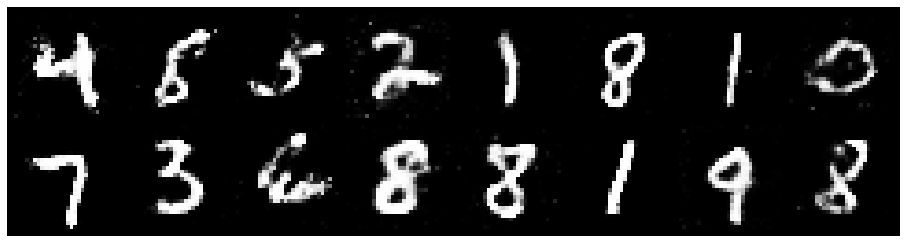

In [0]:
logger.log_images(
          test_images, num_test_samples, 
          epoch, batch_number, num_batches
          );